# Script to plot EKE and wind stress over a chosen box

This script is designed so that we can select an individual box and compute:
 * The EKE for each member over that box
 * The ensemble mean EKE over that box
 * The wind stress over that box
 * The lagged cross-correlation between EKE and stress
 
It is slow, even distributed over multiple cores, so be patient!

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import xarray as xr
import numpy as np
import IPython.display
import pandas as pd
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import os 

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:34568 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.67 GB


In [3]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=1.0)

In [4]:
HardDisk = '/g/data/v45/amh157/OCCIPUT/'
EnsembleDir = 'geouv/'

In [5]:
## To load the EKE climatology
climfilename = HardDisk+EnsembleDir+'eke_climatology.nc'
eke_month = xr.open_dataset(climfilename).EKE

In [10]:
# function to process and plot eke and tau, and NOT save as files
def proc_plot_eke_box(desc, lon1,  lon2, lat1,  lat2, ax_p, ax_b, ax_pt):
    nfiles = 5 #0
    nn=0
    start = pd.datetime(1980,1,1) ## start time for plotting
    col = 'r'  ## colour for plotting
    
    ax_b.plot([lon1, lon2, lon2, lon1, lon1],[lat1,lat1,lat2,lat2,lat1],
            color=col,linewidth=2,transform=ccrs.PlateCarree())
    
    for ii in range(1,nfiles+1):
        nn+=1
        i00 = '%03d' % ii
        Member = 'e'+i00
        ekefilename = HardDisk+EnsembleDir+Member+'/eke_'+i00+'_????.nc'
        
        eke = xr.open_mfdataset(ekefilename).EKE
    
        eke = eke.sel(lon=slice(lon1,lon2)).sel(lat=slice(lat1,lat2)).mean('lon').mean('lat')
        eke = eke.rolling(time=13,center=True).mean()
        eke.plot(ax=ax_p,color=[0.5, 0.5, 0.5],linewidth=0.5)
        
        if nn==1:
            eke_sum = eke
        else:
            eke_sum = eke_sum + eke
            
        print(ekefilename)
            
    eke_sum = eke_sum/nn
    eke_sum.plot(ax=ax_p,color=col,linewidth=1.5)
    ax_p.set_xlabel('Time')
    ax_p.set_ylabel('EKE',color=col)
    ax_p.set_title(desc,' R = 0.1f'%ratio)
    
    taufilename = HardDisk+EnsembleDir+'tau/'+'tau_????.nc'
    tau = xr.open_mfdataset(taufilename).tau
    
    tau = tau.sel(lon=slice(lon1,lon2)).sel(lat=slice(lat1,lat2)).mean('lon').mean('lat')
    tau = tau.rolling(time=13,center=True).mean()
    tau.plot(ax=ax_pt,color='k',linewidth=1,linestyle='--')
    ax_pt.set_ylim(ymin=0.08)
    ax_pt.set_ylabel('Wind Stress')


CPU times: user 36.8 s, sys: 7.47 s, total: 44.3 s
Wall time: 2min 2s


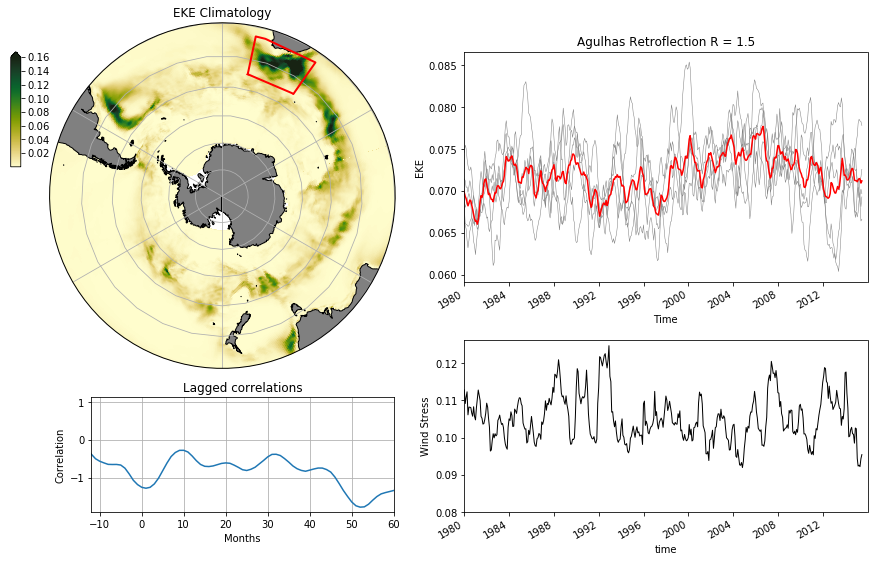

In [42]:
%%time
plt.figure(figsize=(14, 8))

## What shall we call this box?
desc = 'Agulhas Retroflection'

## These numbers set the extent of our box
lon1 = 12
lon2 = 35
lat1 = -45
lat2 = -33

## Other things to set
nfiles = 5 #0
nn=0
col = 'r'
start = pd.datetime(1980,1,1) ## start time for plotting
end = pd.datetime(2015,12,31)

## First, make axes for the map, and plot EKE Climatology
ax_map = plt.axes([0.03,0.35,0.4,0.6],projection=ccrs.SouthPolarStereo())
ax_map.set_extent([-287, 73, -80, -30], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax_map.set_boundary(circle, transform=ax_map.transAxes)
ax_map.add_feature(land_50m)
ax_map.gridlines()

## Load EKE climatology
climfilename = HardDisk+EnsembleDir+'eke_climatology.nc'
eke_month = xr.open_dataset(climfilename).EKE
p1 = eke_month.mean('month').plot(ax=ax_map,cmap=cm.cm.speed,vmax=0.16,add_colorbar=False,transform=ccrs.PlateCarree())
plt.title('EKE Climatology')

# Add colorbar
ax_col = plt.axes([0.02,0.7,0.01,0.2])
plt.colorbar(p1,cax=ax_col,orientation='vertical',extend='max')

## Add lines to show our region of interest on the map
ax_map.plot([lon1, lon2, lon2, lon1, lon1],[lat1,lat1,lat2,lat2,lat1],
            color=col,linewidth=2,transform=ccrs.PlateCarree())

## Axes to plot EKE
ax_eke = plt.axes([0.47,0.5,0.4,0.4])
eke_results = []
for ii in range(1,nfiles+1):
    nn+=1
    i00 = '%03d' % ii
    Member = 'e'+i00
    ekefilename = HardDisk+EnsembleDir+Member+'/eke_'+i00+'_????.nc'
        
    eke = xr.open_mfdataset(ekefilename).EKE
    
    eke = eke.sel(lon=slice(lon1,lon2)).sel(lat=slice(lat1,lat2)).mean('lon').mean('lat')
    eke = eke.rolling(time=13,center=True).mean()
    eke.plot(ax=ax_eke,color=[0.5, 0.5, 0.5],linewidth=0.5)
    
    result = {'ii': ii,'eke': eke}
    eke_results.append(result)
    
    if ii==1:
        eke_sum = eke
    else:
        eke_sum = eke_sum + eke
                        
eke_sum = eke_sum.load()/nn
eke_sum.plot(ax=ax_eke,color=col,linewidth=1.5)
ax_eke.set_xlabel('Time')
ax_eke.set_ylabel('EKE')
ax_eke.set_xlim([start,end])

# Compute variance ratios from saved results
for result in eke_results:
    ii = result['ii']
    eke = result['eke']
    
    if ii==1:
        eke_var = (eke - eke_sum)**2
    else:
        eke_var = eke_var + (eke - eke_sum)**2
        
eke_var = eke_var.load()/nn
sigma2 = np.var(eke_sum)  
epsilon2 = eke_var.mean('time')
ratio = (epsilon2/sigma2)**0.5
ax_eke.set_title(desc+' R = %0.1f'%ratio.values)

## Axes to plot the wind
ax_tau = plt.axes([0.47,0.1,0.4,0.3])
taufilename = HardDisk+EnsembleDir+'tau/'+'tau_????.nc'
tau = xr.open_mfdataset(taufilename).tau
    
tau = tau.sel(lon=slice(lon1,lon2)).sel(lat=slice(lat1,lat2)).mean('lon').mean('lat')
tau = tau.rolling(time=13,center=True).mean()
tau.plot(ax=ax_tau,color='k',linewidth=1)
ax_tau.set_ylim(ymin=0.08)
ax_tau.set_ylabel('Wind Stress')
ax_tau.set_xlim([start,end])

## Axes to plot lagged correlation
ax_corr = plt.axes([0.1,0.1,0.3,0.2])
ekep = eke_sum[6:-6] - eke_sum.mean()
taup = tau[6:-6] - tau.mean()
coef = np.correlate(ekep,taup,mode='full')
lag = coef.argmax() - ekep.shape[0] + 1
nn = ekep.shape[0]
ax_corr.plot(np.arange(-nn+1,nn),coef/coef.max())

plt.xlim([-12,60])
plt.title('Lagged correlations')
plt.xlabel('Months')
plt.ylabel('Correlation')
plt.grid()

plt.savefig('temp.png')